# Лабораторная работа 2.


Выполнил Баулкин Данир М8О-312Б-23

РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)


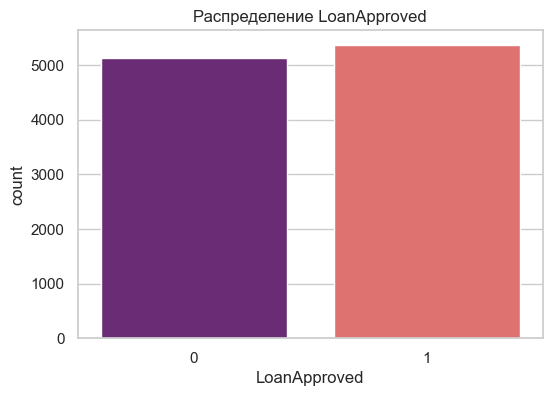

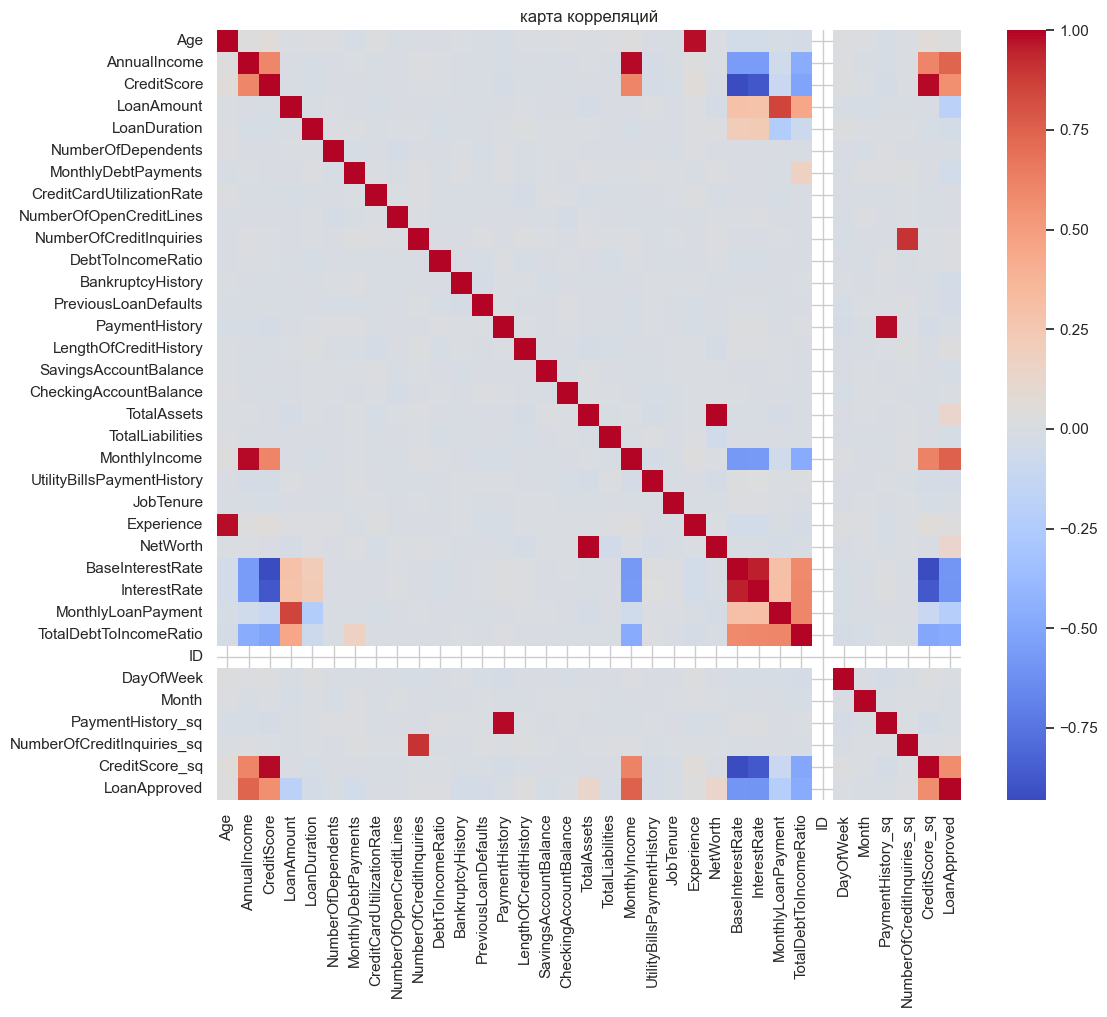

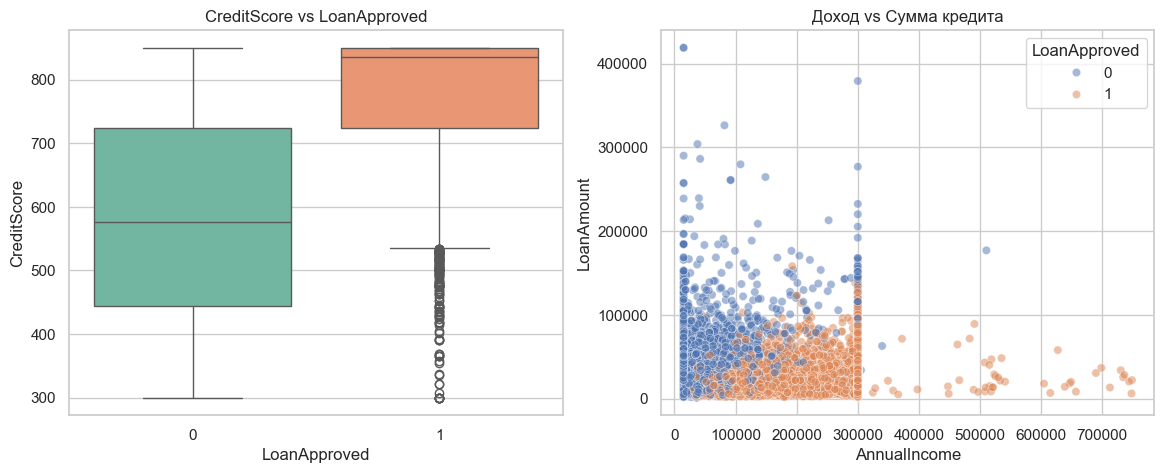

Дисбаланс классов практически отсутствует (~51/49)
CreditScore — самый значимый признак, у одобренных заявок он заметно выше
Сильная корреляция между AnnualIncome и LoanAmount указывает на мультиколлинеарность
ЗАДАНИЯ 6-9
                       My   Sklearn
Accuracy         0.905148  0.905148
Precision        0.889581  0.889581
Recall           0.930168  0.930168
F1-Score         0.909422  0.909422
AUC-ROC (Bonus)  0.967508  0.967508
Собственные реализации метрик  совпадают с библиотечными аналогами из Sklearn до 9-го знака.
РЕАЛИЗАЦИЯ CLASSIFIER
My Bagging ROC-AUC: 0.9757
Sklearn Bagging ROC-AUC: 0.9746

[ВЫВОД ПО ЗАДАНИЮ 2]:
Класс MyBagging успешно обучает ансамбль моделей. Результат сопоставим со Sklearn.
СРАВНЕНИЕ БУСТИНГОВ
My GB           | ROC-AUC: 0.9751
Sklearn GB      | ROC-AUC: 0.9809
XGBoost         | ROC-AUC: 0.9818
LightGBM        | ROC-AUC: 0.9829


[I 2025-12-22 14:48:04,595] A new study created in memory with name: no-name-20d10efb-9729-4f3b-85da-3b7da5748202


CatBoost        | ROC-AUC: 0.9831
Лучший алгоритм - CatBoost с ROC-AUC 0.9831.
ОПТИМИЗАЦИЯ OPTUNA


[I 2025-12-22 14:48:05,006] Trial 0 finished with value: 0.9822400197858473 and parameters: {'num_leaves': 24, 'max_depth': 7, 'learning_rate': 0.06950473063639274, 'n_estimators': 179}. Best is trial 0 with value: 0.9822400197858473.
[I 2025-12-22 14:48:05,380] Trial 1 finished with value: 0.9788529664222532 and parameters: {'num_leaves': 28, 'max_depth': 5, 'learning_rate': 0.01612459021699905, 'n_estimators': 205}. Best is trial 0 with value: 0.9822400197858473.
[I 2025-12-22 14:48:05,857] Trial 2 finished with value: 0.9826037302141528 and parameters: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.07964860727560727, 'n_estimators': 149}. Best is trial 2 with value: 0.9826037302141528.
[I 2025-12-22 14:48:06,082] Trial 3 finished with value: 0.9785747279445997 and parameters: {'num_leaves': 44, 'max_depth': 4, 'learning_rate': 0.022393265847927765, 'n_estimators': 162}. Best is trial 2 with value: 0.9826037302141528.
[I 2025-12-22 14:48:06,566] Trial 4 finished with value: 0

Лучшие параметры Optuna: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.07964860727560727, 'n_estimators': 149}
Гиперпараметры с ROC-AUC 0.9826.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc,
    classification_report
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")

def run_eda(df):
    print("РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA)")
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='LoanApproved', data=df, palette='magma')
    plt.title("Распределение LoanApproved")
    plt.show()
    
    plt.figure(figsize=(12, 10))
    numeric_data = df.select_dtypes(include=[np.number])
    correlation = numeric_data.corr()
    sns.heatmap(correlation, cmap='coolwarm', annot=False, fmt=".1f")
    plt.title("карта корреляций")
    plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.boxplot(x='LoanApproved', y='CreditScore', data=df, ax=axes[0], palette='Set2')
    axes[0].set_title("CreditScore vs LoanApproved")
    
    sns.scatterplot(x='AnnualIncome', y='LoanAmount', hue='LoanApproved', data=df, alpha=0.5, ax=axes[1])
    axes[1].set_title("Доход vs Сумма кредита")
    plt.show()

    print("Классы почти не имеют дисбаланса ~51/49")
    print("CreditScore — самый значимый признак, у одобренных заявок он заметно выше")
    print("Сильная корреляция между AnnualIncome и LoanAmount указывает на мультиколлинеарность")


#6-9
class MyMetrics:
    @staticmethod
    def accuracy(y_true, y_pred):
        return np.mean(np.array(y_true) == np.array(y_pred))

    @staticmethod
    def precision(y_true, y_pred):
        y_t, y_p = np.array(y_true), np.array(y_pred)
        tp = np.sum((y_t == 1) & (y_p == 1))
        fp = np.sum((y_t == 0) & (y_p == 1))
        return tp / (tp + fp + 1e-15)

    @staticmethod
    def recall(y_true, y_pred):
        y_t, y_p = np.array(y_true), np.array(y_pred)
        tp = np.sum((y_t == 1) & (y_p == 1))
        fn = np.sum((y_t == 1) & (y_p == 0))
        return tp / (tp + fn + 1e-15)

    @staticmethod
    def f1(y_true, y_pred):
        p = MyMetrics.precision(y_true, y_pred)
        r = MyMetrics.recall(y_true, y_pred)
        return 2 * p * r / (p + r + 1e-15)

    @staticmethod
    def auc_roc(y_true, y_prob):
        desc_score_indices = np.argsort(y_prob, kind="mergesort")[::-1]
        y_true = np.array(y_true)[desc_score_indices]
        y_prob = np.array(y_prob)[desc_score_indices]
        distinct_value_indices = np.where(np.diff(y_prob))[0]
        threshold_indices = np.r_[distinct_value_indices, y_true.size - 1]
        tps = np.cumsum(y_true)[threshold_indices]
        fps = 1 + threshold_indices - tps
        tps = np.r_[0, tps]
        fps = np.r_[0, fps]
        fpr = fps / fps[-1]
        tpr = tps / tps[-1]
        return auc(fpr, tpr)

def prepare_dataset(train_path, test_path):
    train = pd.read_csv(train_path).dropna(subset=['LoanApproved'])
    test = pd.read_csv(test_path)
    target = train['LoanApproved'].astype(int)
    train_size = len(train)
    df = pd.concat([train.drop('LoanApproved', axis=1), test], axis=0)
    
    df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
    df['DayOfWeek'] = df['ApplicationDate'].dt.dayofweek
    df['Month'] = df['ApplicationDate'].dt.month
    df.drop('ApplicationDate', axis=1, inplace=True)
    
    poly_features = ["PaymentHistory", "NumberOfCreditInquiries", "CreditScore"]
    for col in poly_features:
        if col in df.columns:
            df[f"{col}_sq"] = df[col] ** 2

    num_cols = df.select_dtypes(exclude=['object']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df.iloc[:train_size], df.iloc[train_size:], target

#2
class MyBagging(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, n_estimators=10, sample_ratio=0.8):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.sample_ratio = sample_ratio
        self.models = []

    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.models = []
        n_samples = int(len(X) * self.sample_ratio)
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), size=n_samples, replace=True)
            m = clone(self.base_model)
            m.fit(X[indices], y[indices])
            self.models.append(m)
        return self

    def predict_proba(self, X):
        X = np.array(X)
        preds = np.array([m.predict_proba(X)[:, 1] for m in self.models])
        avg_probs = np.mean(preds, axis=0)
        return np.vstack([1 - avg_probs, avg_probs]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

#3
class MyGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, lr=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.lr = lr
        self.max_depth = max_depth
        self.trees = []
        self.initial_logit = 0

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X, y = np.array(X), np.array(y).astype(float)
        p = np.mean(y)
        self.initial_logit = np.log(p / (1 - p))
        curr_logits = np.full(len(y), self.initial_logit)
        for _ in range(self.n_estimators):
            probs = self._sigmoid(curr_logits)
            residuals = y - probs
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)
            curr_logits += self.lr * tree.predict(X)
        return self

    def predict_proba(self, X):
        logits = np.full(X.shape[0], self.initial_logit)
        for tree in self.trees:
            logits += self.lr * tree.predict(X)
        probs = self._sigmoid(logits)
        return np.vstack([1 - probs, probs]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)


train_df_proc, test_df_proc, y_all = prepare_dataset('train_c.csv', 'test_c.csv')
run_eda(pd.concat([train_df_proc, y_all], axis=1))

X_train, X_val, y_train, y_val = train_test_split(train_df_proc, y_all, test_size=0.2, random_state=42, stratify=y_all)

print("ЗАДАНИЯ 6-9")
dummy_model = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
dummy_preds = dummy_model.predict(X_val)
dummy_probs = dummy_model.predict_proba(X_val)[:, 1]

metrics_data = {
    "Accuracy": [MyMetrics.accuracy(y_val, dummy_preds), accuracy_score(y_val, dummy_preds)],
    "Precision": [MyMetrics.precision(y_val, dummy_preds), precision_score(y_val, dummy_preds)],
    "Recall": [MyMetrics.recall(y_val, dummy_preds), recall_score(y_val, dummy_preds)],
    "F1-Score": [MyMetrics.f1(y_val, dummy_preds), f1_score(y_val, dummy_preds)],
    "AUC-ROC (Bonus)": [MyMetrics.auc_roc(y_val, dummy_probs), roc_auc_score(y_val, dummy_probs)]
}
df_metrics = pd.DataFrame(metrics_data, index=["My", "Sklearn"]).T
print(df_metrics)

print("Собственные реализации метрик  совпадают с библиотечными аналогами из Sklearn до 9-го знака.")

#2
print("2 РЕАЛИЗАЦИЯ CLASSIFIER")
m_bag = MyBagging(DecisionTreeClassifier(max_depth=5), n_estimators=50).fit(X_train, y_train)
s_bag = BaggingClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=50).fit(X_train, y_train)
auc_m_bag = roc_auc_score(y_val, m_bag.predict_proba(X_val)[:, 1])
auc_s_bag = roc_auc_score(y_val, s_bag.predict_proba(X_val)[:, 1])
print(f"My Bagging ROC-AUC: {auc_m_bag:.4f}")
print(f"Sklearn Bagging ROC-AUC: {auc_s_bag:.4f}")
print("Класс MyBagging успешно обучает ансамбль моделей. Результат сопоставим со Sklearn.")

#3-4
print("3-4 СРАВНЕНИЕ БУСТИНГОВ")
boost_variants = {
    "My GB": MyGradientBoosting(n_estimators=100),
    "Sklearn GB": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0)
}

results = {}
for name, model in boost_variants.items():
    model.fit(X_train, y_train)
    auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    results[name] = auc_score
    print(f"{name:15} | ROC-AUC: {auc_score:.4f}")

best_lib = max(results, key=results.get)
print(f"Лучший алгоритм - {best_lib} с ROC-AUC {results[best_lib]:.4f}.")

#5
print("5 ОПТИМИЗАЦИЯ OPTUNA")
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
    }
    model = LGBMClassifier(**params, verbose=-1, random_state=42)
    model.fit(X_train, y_train)
    return roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(f"Лучшие параметры Optuna: {study.best_params}")
print(f"Гиперпараметры с ROC-AUC {study.best_value:.4f}.")

best_model = LGBMClassifier(**study.best_params, verbose=-1).fit(train_df_proc, y_all)
test_probs = best_model.predict_proba(test_df_proc)[:, 1]
pd.DataFrame({"ID": pd.read_csv('test_c.csv')["ID"], "LoanApproved": test_probs}).to_csv("submission.csv", index=False)